In [1]:
# IMPORTS
from VGG_Pretrain import *
from Build_Histogram import *
from Load_Dataset_Folder import *
from Features_Processing import *
from Linear_Processsing_Pipeline import *
from Training_Poly_Processing_Pipeline import *
from Testing_Poly_Processing_Pipeline import *
from Evaluate_Train_Accuracy_of_Model import *
from LeNet_Implementation import *
from torch import optim
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torchvision.models as models
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
user= 'Max'
root_path = "C:\\Users\\" + user + "\\Documents\\GitHub\\Shark-Species-Classification"
data_path = os.path.join(root_path, 'Genus Carcharhinus')

# SOFTMAX TO GET PROBABILITY
# ABLATION TEST - SEE PAPER FOR REASONING
# Grad CAM or something for visualizing the feature maps

## SVC & KMeans

In [3]:
image_files, labels = load_dataset_folder(data_path)
features, processed_labels = Features_Processing(image_files, labels)

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
'''
Split in training set and testing set.  This preserves the large training set for future testing purposes
'''
train_set = [] 
train_labels = []
test_set = [] 
test_labels = []

for i, (train_index, test_index) in enumerate(sss.split(features, processed_labels)):
    continue
    
for index in train_index:
    train_set.append(features[index])
    train_labels.append(processed_labels[index])
for index in test_index:
    test_set.append(features[index])
    test_labels.append(processed_labels[index])

'''
Split the training set into a smaller training set, train_train, and a validation set
'''
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for i, (train_train_index, val_index) in enumerate(sss.split(train_set, train_labels)):
    continue

val_set = [] 
val_labels = []
for index in val_index:
    val_set.append(train_set[index])
    val_labels.append(train_labels[index])

train_train_set = [] 
train_train_labels = []
for index in train_train_index:
    train_train_set.append(train_set[index])
    train_train_labels.append(train_labels[index])
    
    


In [7]:
c, d, k = Poly_Processing_Pipeline(train_train_set, val_set, train_train_labels, val_labels)

print("c: ", c)
print("d: ", d)
print("k: ", k)

training_accuracy = Testing_Poly_SVC(train_train_set, val_set, train_train_labels, val_labels, c, d, k)
testing_accuracy = Testing_Poly_SVC(train_set, test_set, train_labels, test_labels,c, d, k)


print("Training Accuracy: ", training_accuracy)
print("Testing Accuracy: ", testing_accuracy)

c:  1.0
d:  2
k:  9
Training Accuracy:  0.8235294117647058
Testing Accuracy:  0.7192982456140351


## VGG Pretrained

In [19]:
dataset = ImageLoader(data_path)

train_dataset, test_dataset = Dataset_Splitter(.5, dataset)
train_train_dataset, validation_dataset = Dataset_Splitter(.9, train_dataset)

In [20]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_train_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(validation_dataset,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                                batch_size=BATCH_SIZE)

In [14]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

OUTPUT_DIM = 9
model = VGG(vgg11_layers, OUTPUT_DIM)

In [15]:
pretrained_model = models.vgg11_bn(pretrained=True)

IN_FEATURES = pretrained_model.classifier[-1].in_features
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

pretrained_model.classifier[-1] = final_fc

D:\Anaconda\envs\SharkGPUV2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\SharkGPUV2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model.load_state_dict(pretrained_model.state_dict())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 128,808,713 trainable parameters


In [17]:
LR = 1e-3
params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=LR)

device = torch.device('cuda')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [25]:

EPOCHS = 7

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):


    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'VGG-model_2.pt')


    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 2.147 | Train Acc: 24.81%
	 Val. Loss: 1.775 |  Val. Acc: 41.67%


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 1.029 | Train Acc: 70.02%
	 Val. Loss: 3.330 |  Val. Acc: 25.00%


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 0.390 | Train Acc: 87.35%
	 Val. Loss: 1.785 |  Val. Acc: 58.33%


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 0.200 | Train Acc: 96.52%
	 Val. Loss: 2.240 |  Val. Acc: 25.00%


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 0.026 | Train Acc: 99.22%
	 Val. Loss: 2.937 |  Val. Acc: 50.00%


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 0.071 | Train Acc: 97.87%
	 Val. Loss: 2.565 |  Val. Acc: 50.00%


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 1.720 |  Val. Acc: 58.33%


In [29]:
model.load_state_dict(torch.load('VGG-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.745 | Test Acc: 85.11%


## Grad CAM

In [9]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import vgg16, vgg11
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torchvision import transforms

In [12]:
rgb_img = Image.open(os.path.join(data_path, 'Bull', 'BU3-3-2-resized.JPG'))

transform = transforms.Compose([transforms.CenterCrop(224)])
    
convert_tensor = transform(rgb_img)

cropped_image = np.array(convert_tensor, np.float32)

cv2.imwrite("croppedimage.jpg", cropped_image)

True

(224, 224, 3)
torch.Size([1, 3, 224, 224])
(224, 224)


(-0.5, 223.5, 223.5, -0.5)

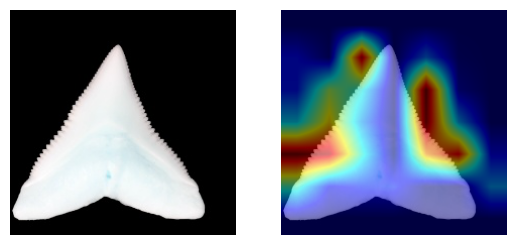

In [31]:
rgb_img = Image.open(os.path.join(data_path, 'Bull', 'croppedimage.JPG'))

rgb_img=np.array(rgb_img, np.float32)

rgb_img *= (1.0/rgb_img.max())

convert2 = transforms.ToTensor()


input_tensor = convert2(rgb_img).unsqueeze(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


target_layers = [model.features[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device)


targets = [ClassifierOutputTarget(3)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]



print(rgb_img.shape)
print(input_tensor.size())
print(grayscale_cam.shape)
#rgb_img = rgb_img.reshape()

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

f, axarr = plt.subplots(1,2) 
axarr[0].imshow(rgb_img)
axarr[0].axis('off')
axarr[1].imshow(visualization)
axarr[1].axis('off')

In [28]:
rgb_img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

### Visualizing Feature Maps

In [25]:
no_of_layers = 0
conv_layers = []

model_children = list(model.children())

for child in model_children:
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(no_of_layers)



8


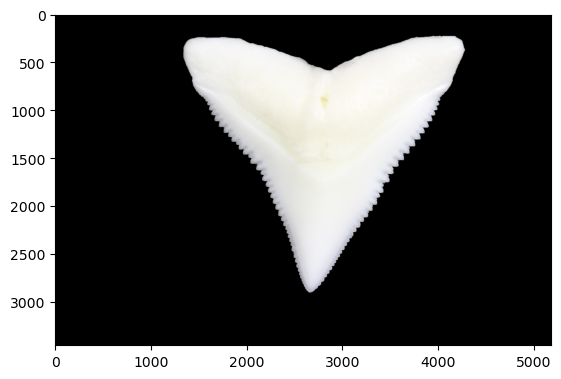

In [31]:
img = cv2.imread(os.path.join(data_path, 'Bull', 'BU3-3-2.JPG'))

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img=np.array(img)
img=transform(img)
img=img.unsqueeze(0)


In [32]:


results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


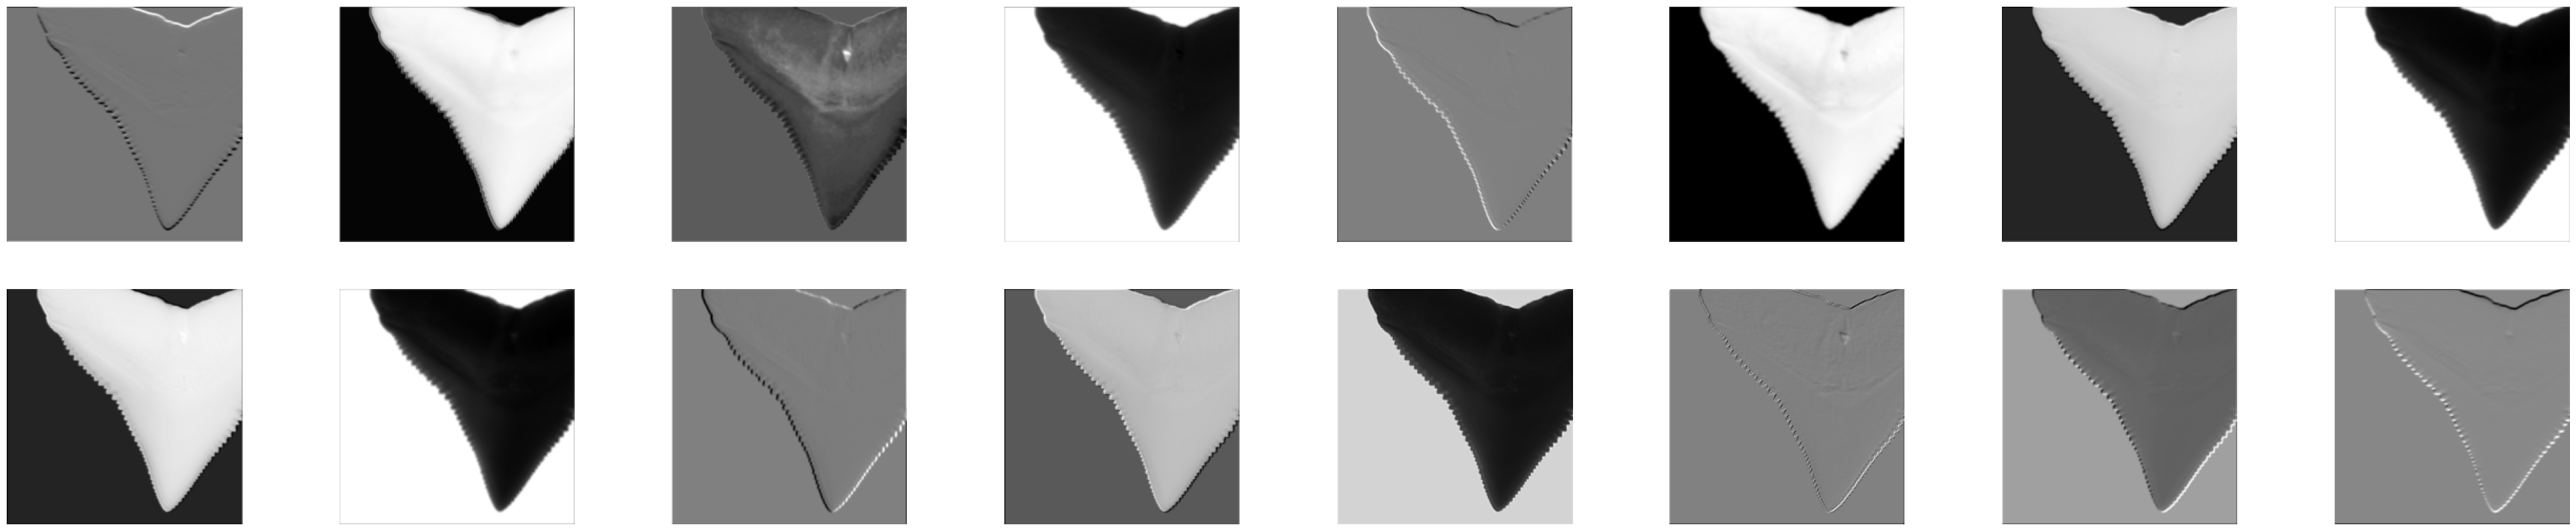

Layer  2


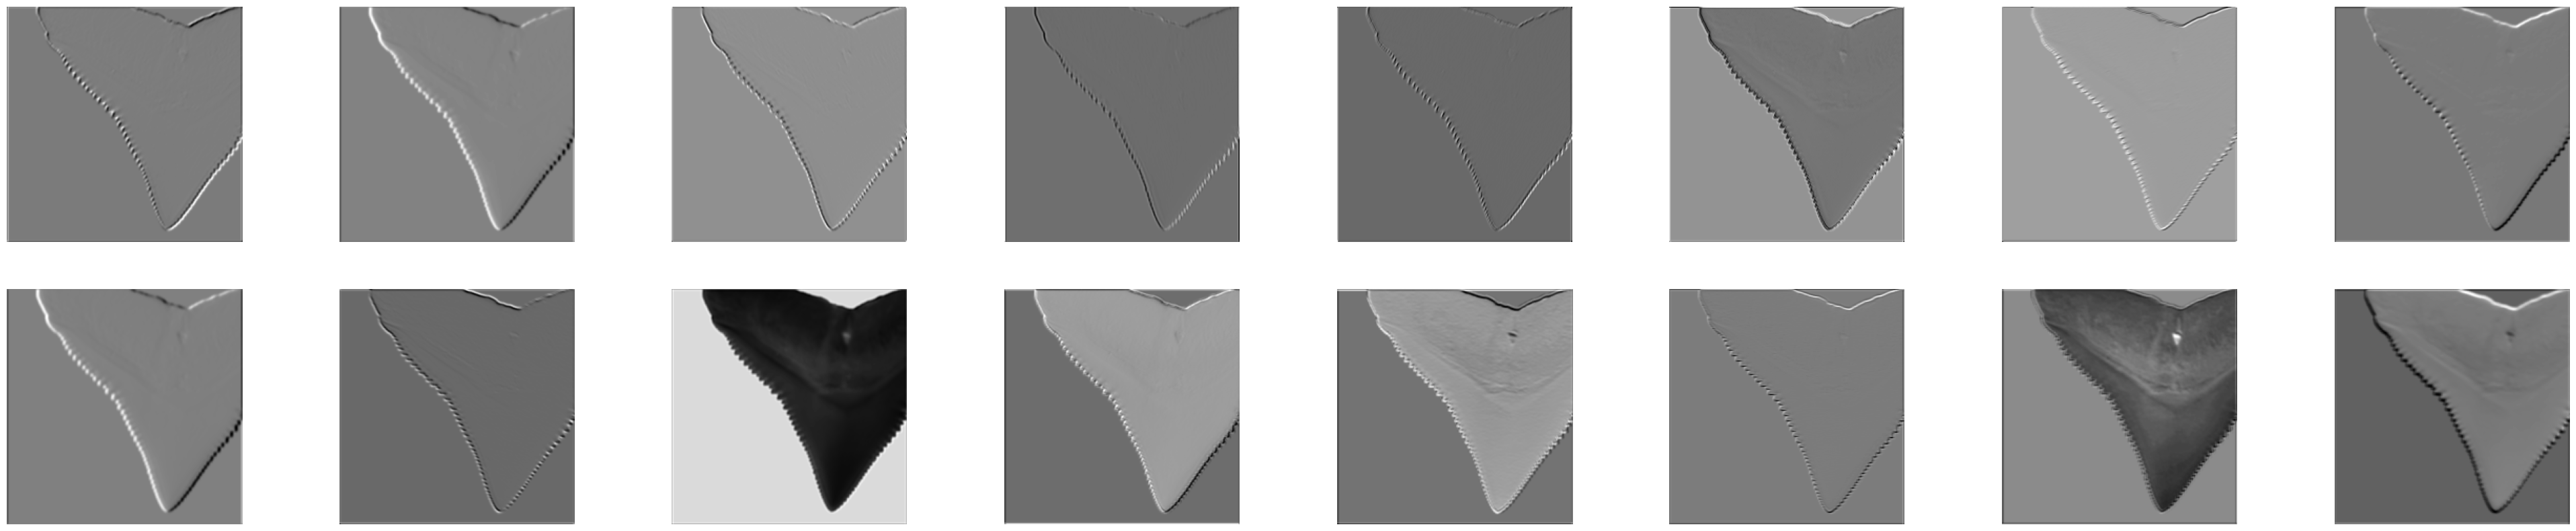

Layer  3


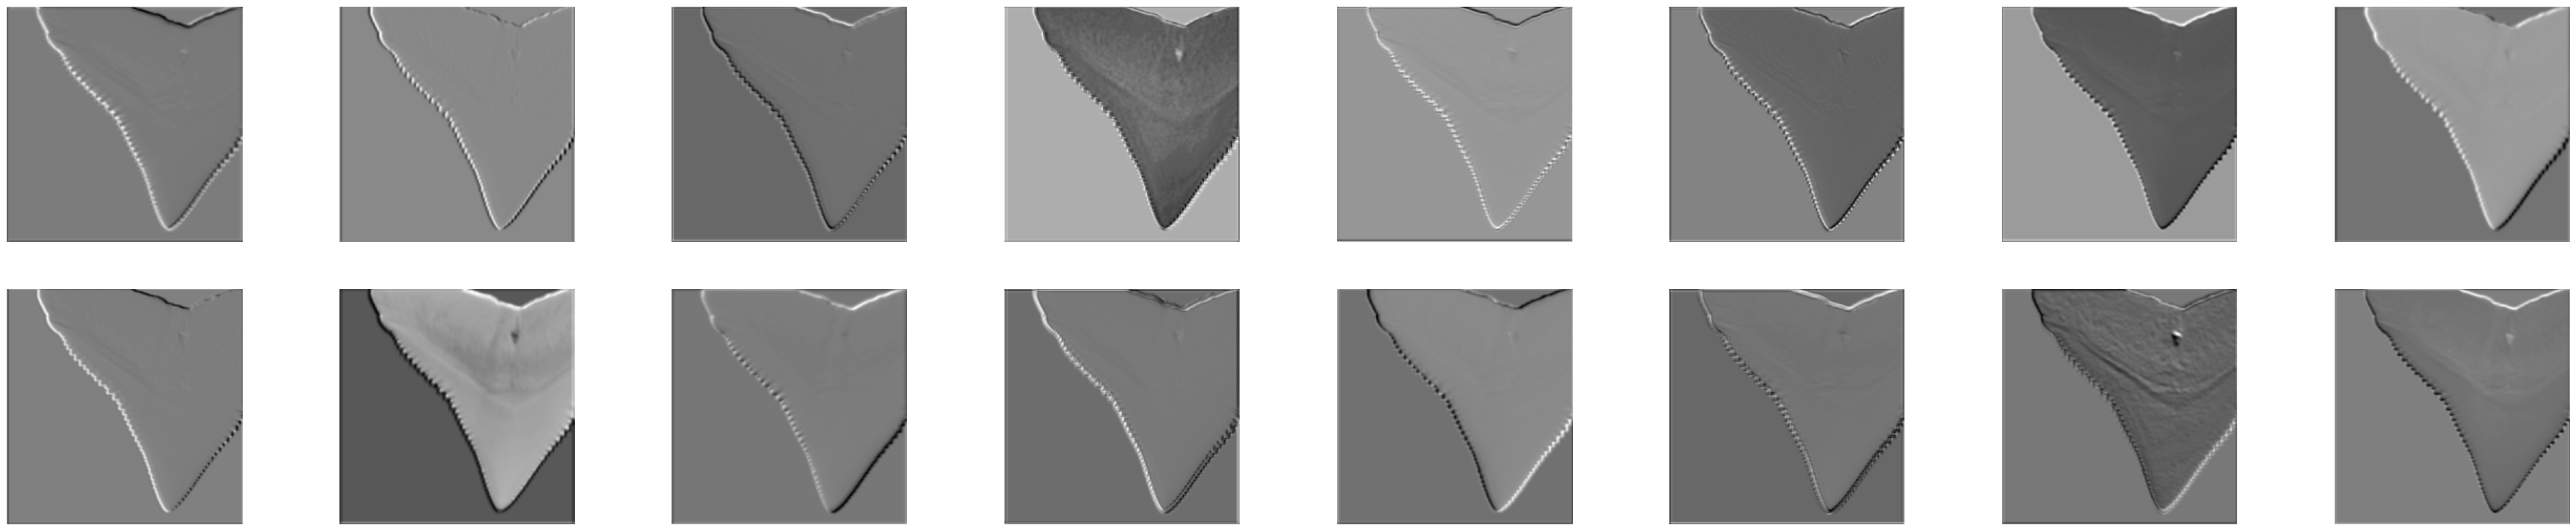

Layer  4


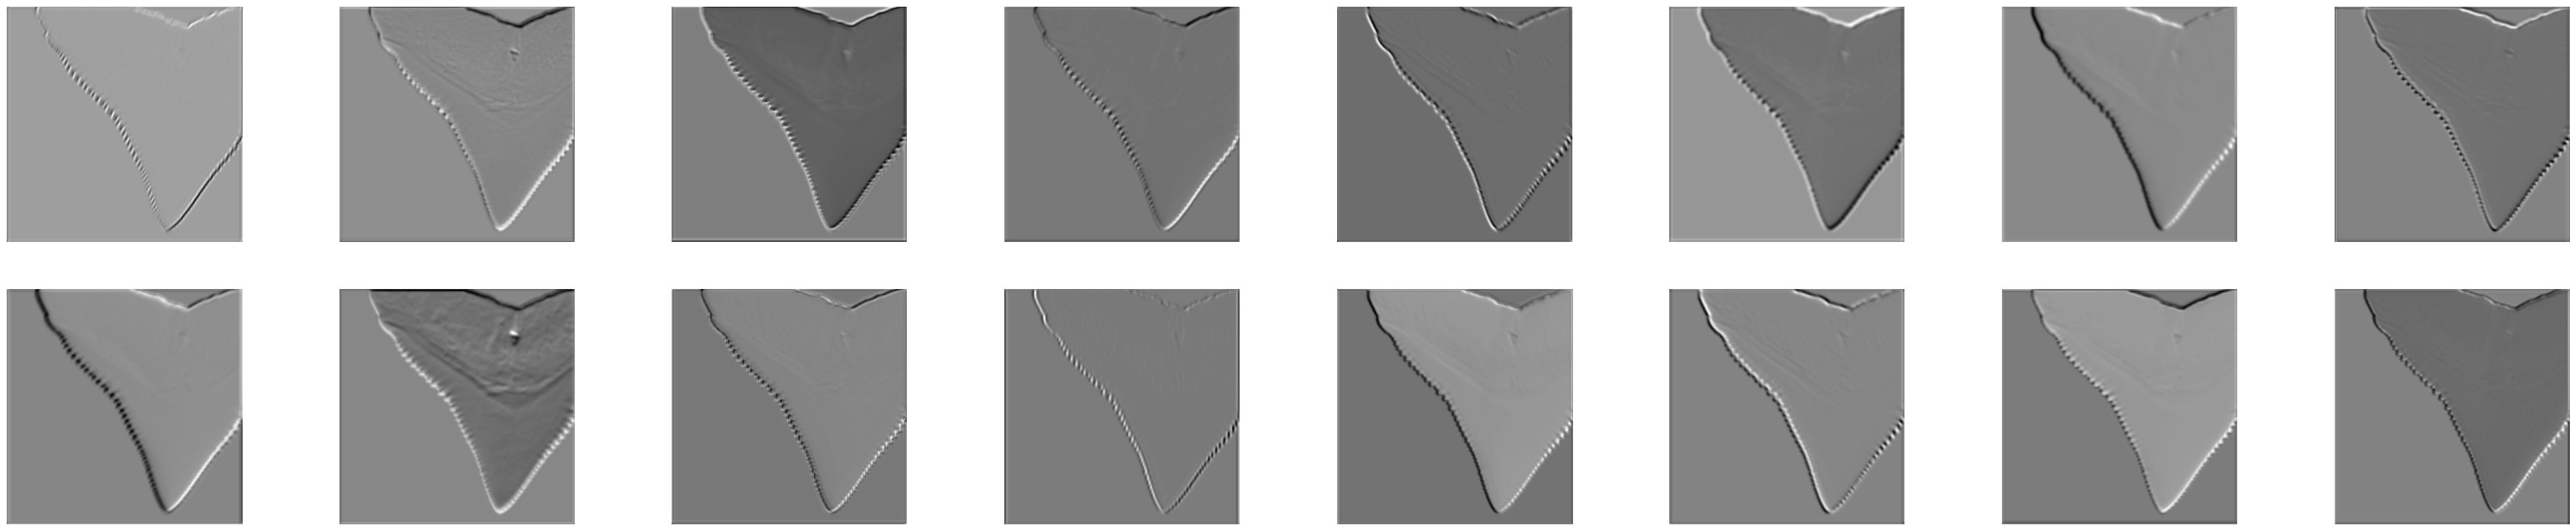

Layer  5


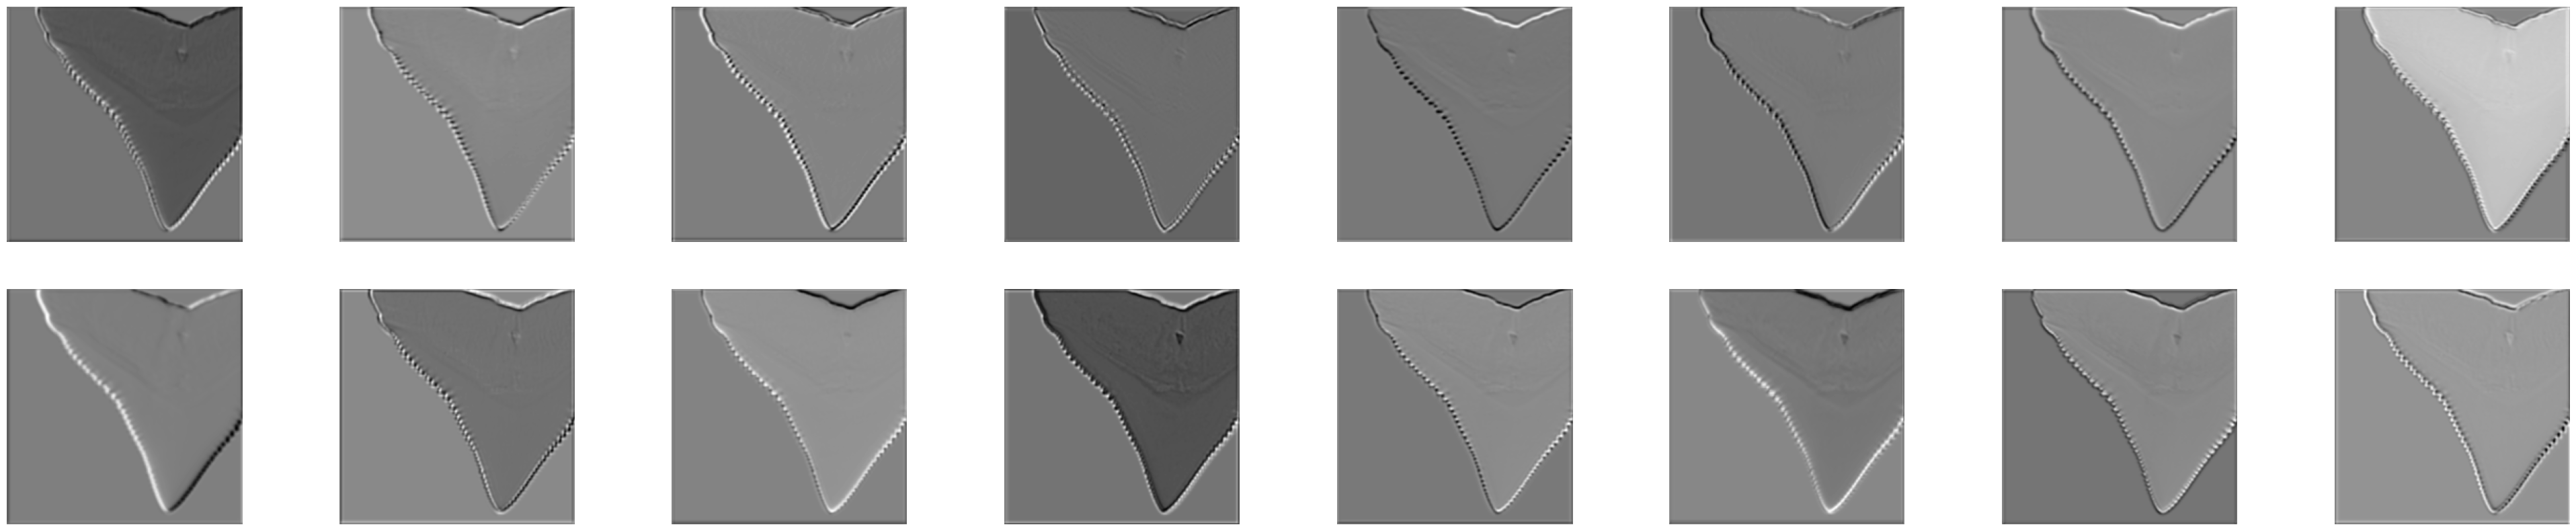

Layer  6


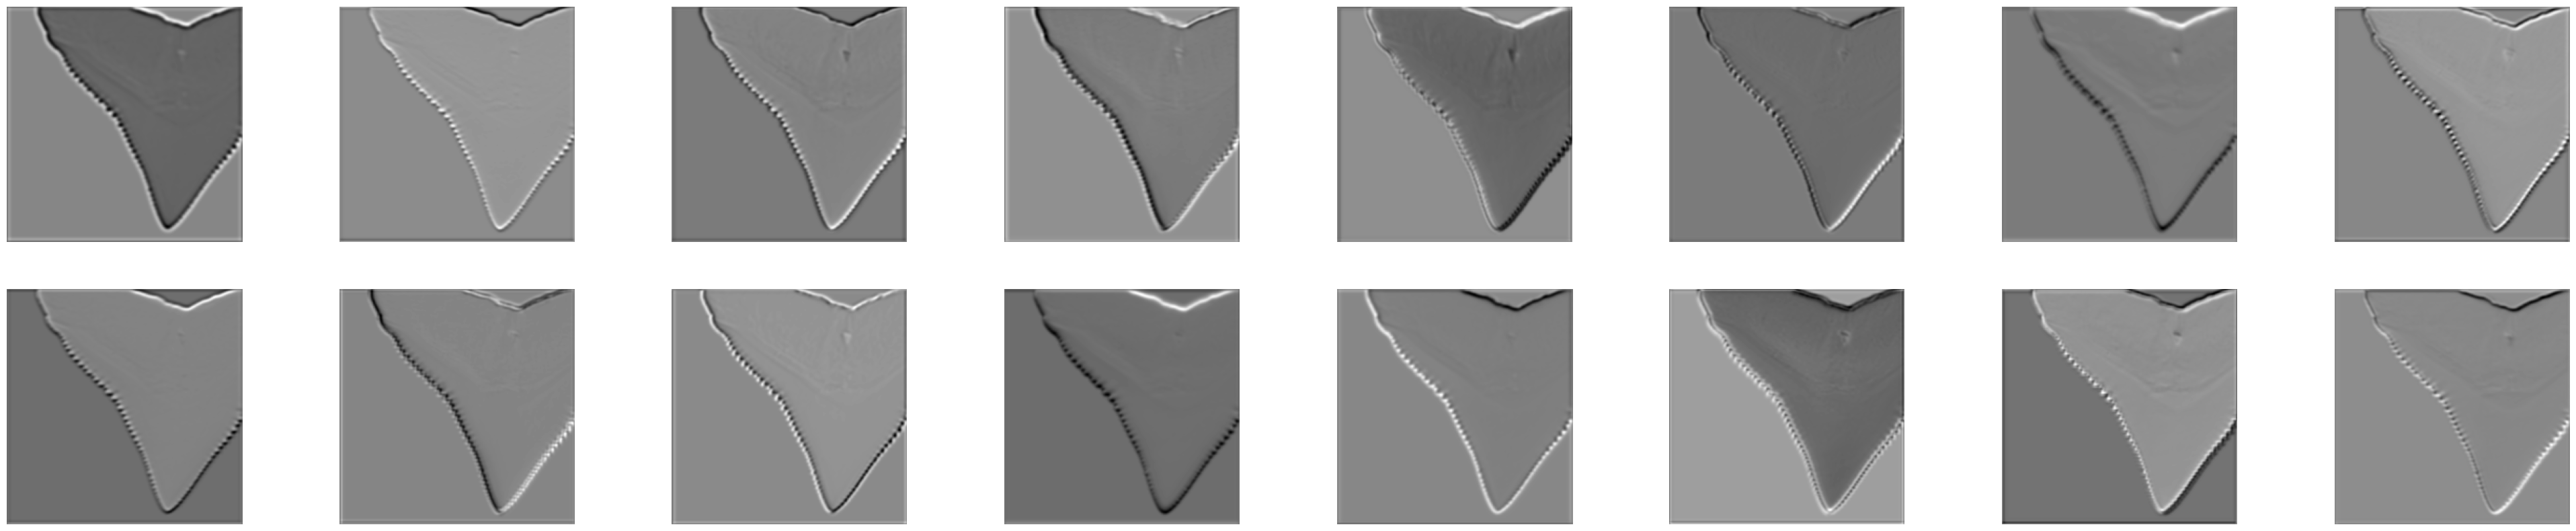

Layer  7


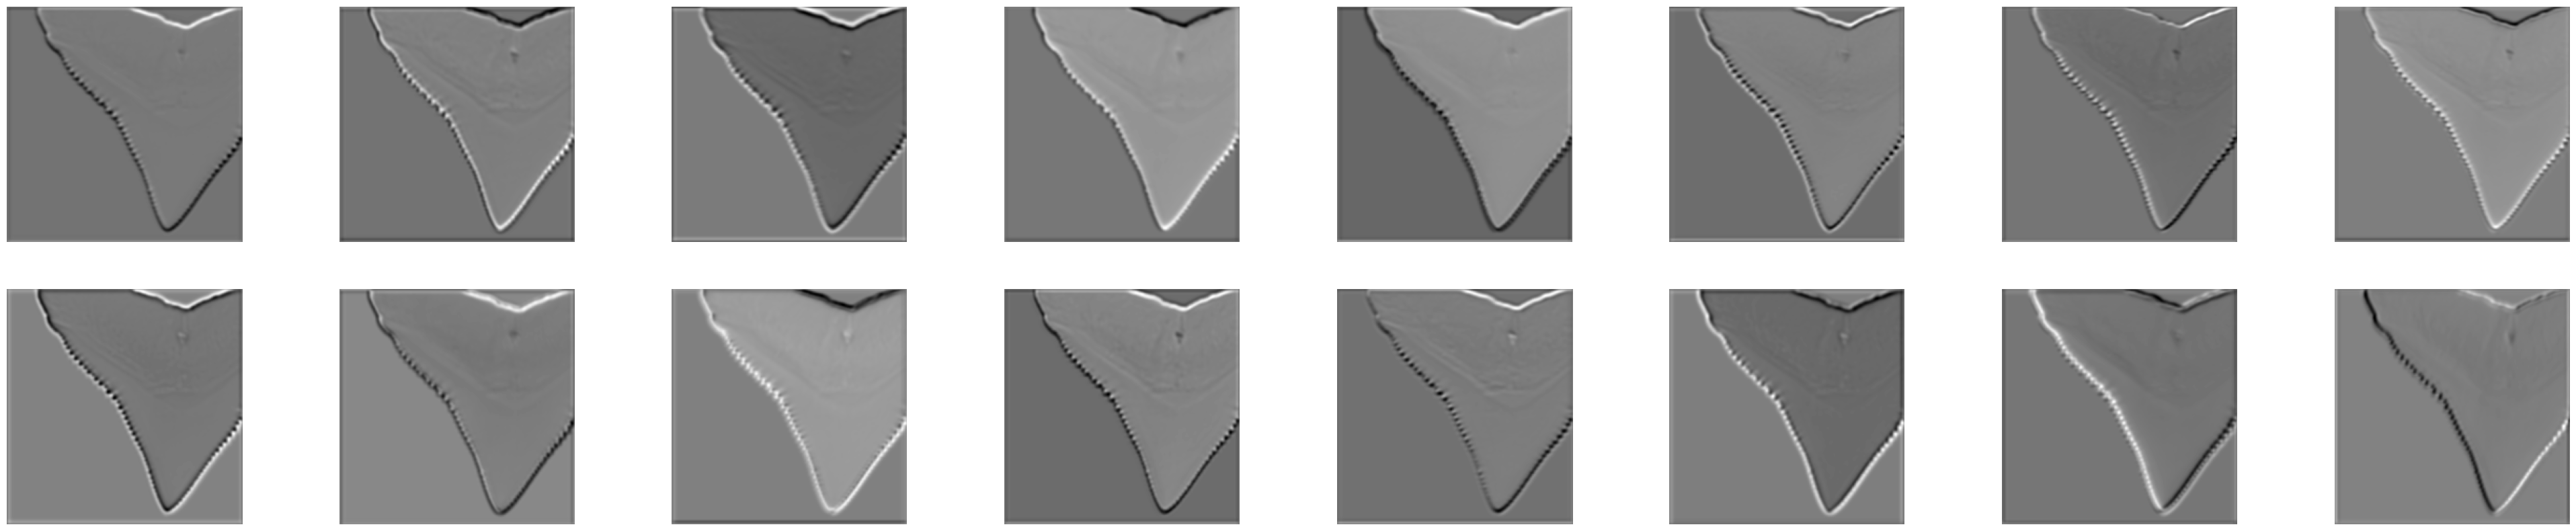

Layer  8


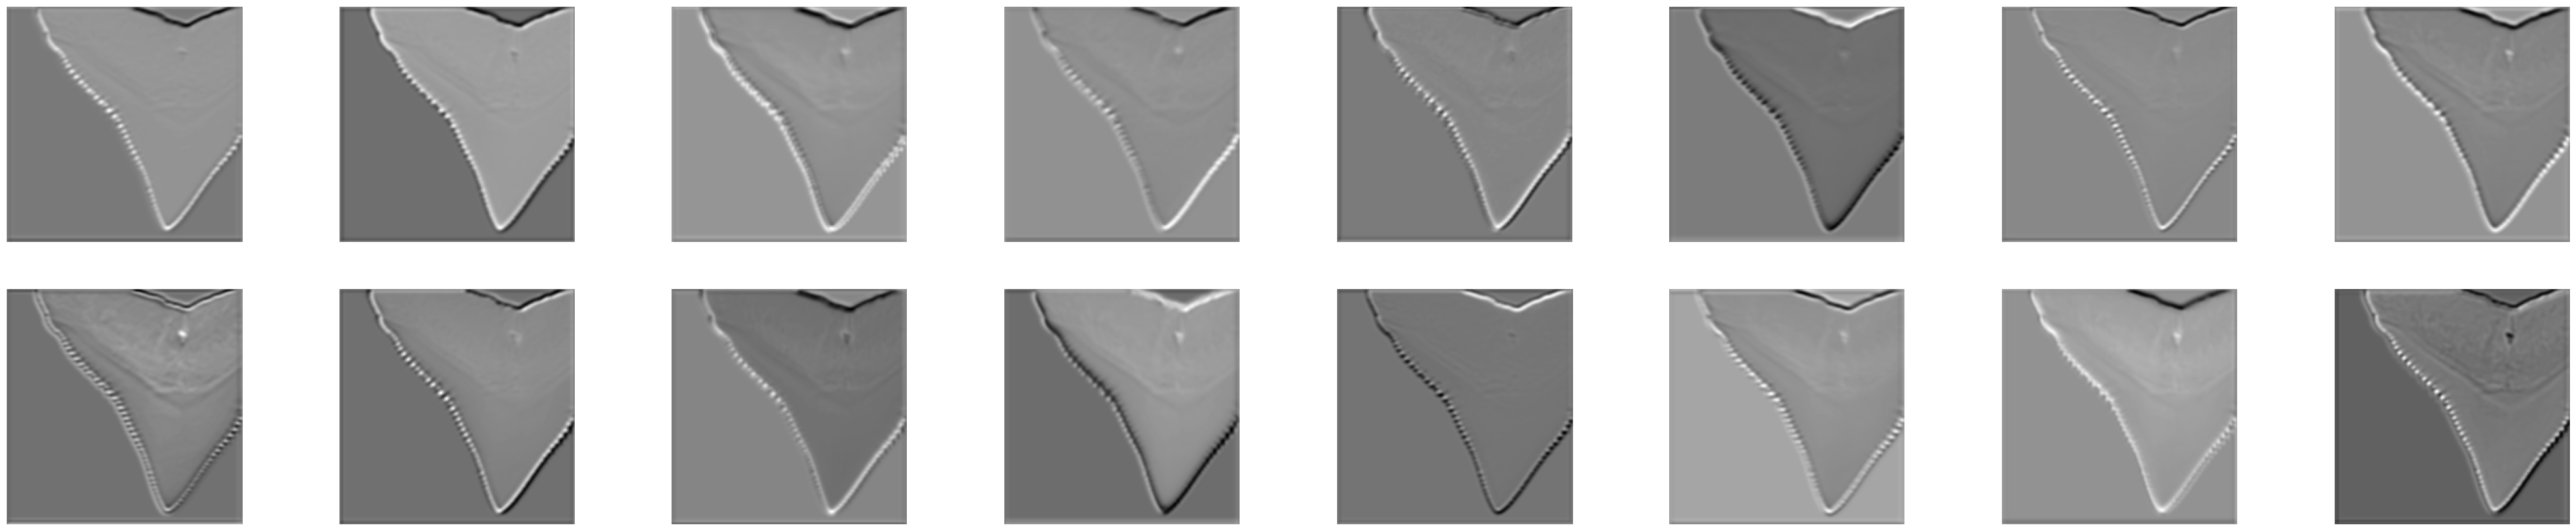

In [40]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
        
    plt.show()
    plt.close()


## Custom CNN

In [ ]:
OUTPUT_DIM = 9
model = AlexNet(OUTPUT_DIM)

In [13]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda') #if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = [1,3,5,10,15,20,30]
EPOCHS = 7

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'MMnet-model.pt')

    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

NameError: name 'model' is not defined